# Read in the data

Data we'll work is here [SAT Results](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)

In [2]:
import pandas as pd
import numpy as np
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [10]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [11]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [12]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [13]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [14]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[abs(correlations) > 0.25])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF LARGEST CLASS                   0.314434
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_percent                            -0.398750
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
black_per                              -0.284139
hispanic_per                           -0.396985
white_num           

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/generic.py:5135: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


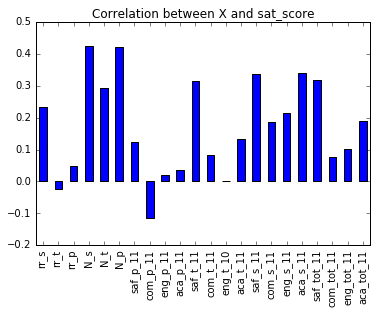

In [15]:
correlations.loc[survey_fields[1:]].plot(kind = 'bar', title = 'Correlation between X and sat_score')

All data is here: [SAT scores surveys](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8), we can find discriptions of the names in Survey Data Dictionary file in ZIP archive.

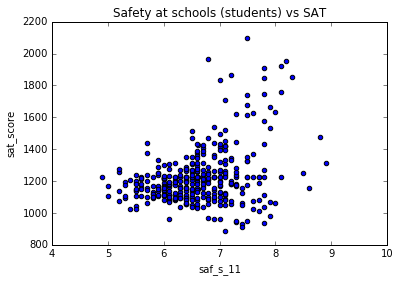

In [16]:
combined.plot.scatter('saf_s_11', 'sat_score', title = 'Safety at schools (students) vs SAT')

In [27]:
combined.columns.tolist()

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

In [17]:
districts = combined.groupby('school_dist').aggregate(np.mean)
districts.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


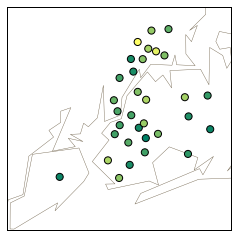

In [18]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
            )

m.drawmapboundary()
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.scatter(districts['lon'].tolist(),
          districts['lat'].tolist(),
          s = 50, zorder = 2, latlon = True,
          c = districts['ell_percent'],
          cmap = 'summer')


[Boroughs of New York City](http://www.nycgo.com/boroughs-neighborhoods) - data to come to conclusion.

In [19]:
race_percents = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

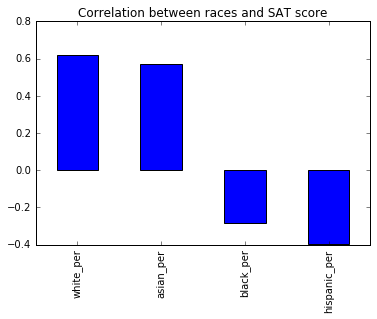

In [23]:
correlations[race_percents].plot(kind = 'bar', title = 'Correlation between races and SAT score')

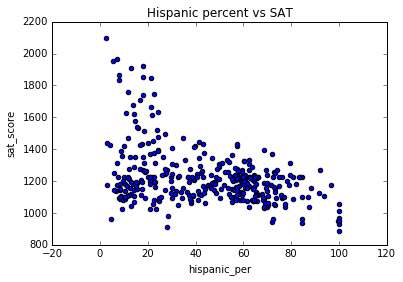

In [35]:
combined.plot.scatter('hispanic_per', 'sat_score', title = 'Hispanic percent vs SAT')

Schools with high percentage of hispanic students (<= 95%).

In [29]:
combined.loc[combined['hispanic_per'] >= 95,'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools with low percentage of hispanic students and average SAT score greater 1800.

In [30]:
combined.loc[(combined['hispanic_per'] <= 10) & (combined['sat_score'] >= 1800),'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

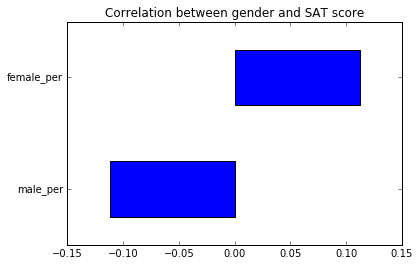

In [34]:
correlations[['male_per','female_per']].plot(kind = 'barh', title = 'Correlation between gender and SAT score')

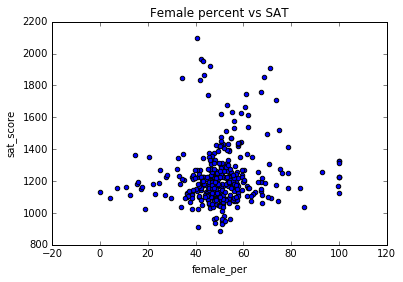

In [36]:
combined.plot.scatter('female_per', 'sat_score', title = 'Female percent vs SAT')

Schools with high SAT score and female percent greater 60

In [37]:
combined.loc[(combined['female_per'] >=60) & (combined['sat_score'] >= 1700),'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [39]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

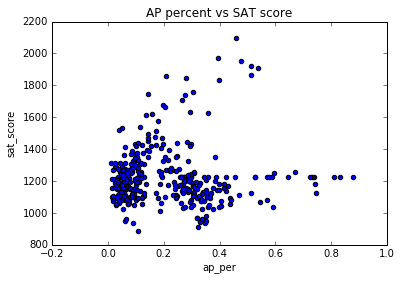

In [41]:
combined.plot.scatter('ap_per', 'sat_score', title = 'AP percent vs SAT score')

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
    * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.